*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# A Day At the Track

This chapter introduces vector addition and subtraction, and a few ways to represent these operations graphically.

To demonstrate these operations, we'll use GPS tracking data I collected.
We'll convert measurements in latitude and longitude to positions in Cartesian coordinates.
Then we'll use differences between successive positions to estimate velocity, and differences between velocities to estimate acceleration.
If you know calculus, you will recognize these steps as a form of numerical differentiation.

Finally, we'll reverse the process: we'll add up accelerations to estimate velocity, and add up velocities to estimate position -- which you might recognize as a form of numerical integration.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/track.ipynb).

In [1]:
# temporary hack to make autoreload work on Colab
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate, plot_vector, plot_vectors, scatter, trajectory, norm

In [4]:
from utils import set_precision

set_precision(4)

## Vector Addition and Subtraction

Let's start with the basics of adding and subtracting vectors -- then we'll see an example where these operations are useful.
We'll use NumPy arrays to store the Cartesian coordinates of two vectors.

In [5]:
A = np.array([1.1, 0.2])
B = np.array([0.1, 0.9])

To add vectors in this representation, we add the coordinates elementwise -- and since that's what array addition does, we can perform vector addition like this.

In [6]:
C = A + B
C

array([1.2, 1.1])

We can think of a vector as a point in the Cartesian plane, so we can draw `A`, `B`, and `C` like this.

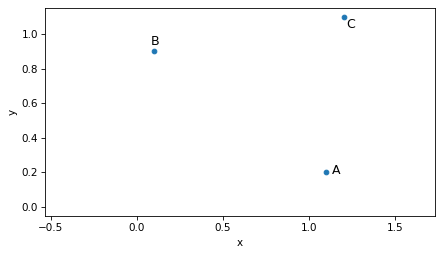

In [7]:
scatter([A, B, C], s=20)
plot_vector(A, label='A', alpha=0)
plot_vector(B, label='B', alpha=0)
plot_vector(C, label='C', label_pos=1, alpha=0, color='C1')
plt.axis('equal')
decorate(xlabel='x', ylabel='y')

It is also common to represent vectors as arrows with their tails at the origin.

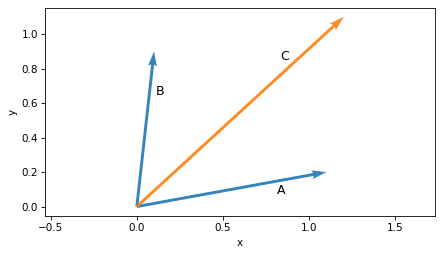

In [8]:
plot_vector(A, label='A', label_pos=2)
plot_vector(B, label='B', label_pos=2)
plot_vector(C, label='C', label_pos=10, color='C1')
plt.axis('equal')
decorate(xlabel='x', ylabel='y')

But it's not necessary to put the tail at the origin.
For example, we could put the tail of `B` at the head of `A`.

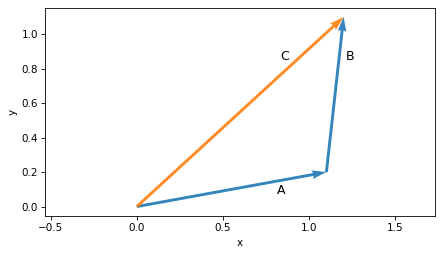

In [9]:
plot_vector(A, label='A', label_pos=2)
plot_vector(C, label='C', label_pos=10, color='C1')
plot_vector(B, origin=A, label='B', label_pos=2)
plt.axis('equal')
decorate(xlabel='x', ylabel='y')

In this arrangement we can see that adding vectors is like lining them up head to tail.
If we start from the origin and follow `A`, then continue from `A` and follow `B`, we arrive at their sum, `C`.

To compute the difference between two vectors, we subtract the coordinates elementwise.

In [10]:
D = B - A
D

array([-1. ,  0.7])

If we plot the result, `D`, with its tail at `A`, we get a graphical representation of subtraction.
And if we follow the arrows, we can see the inverse operation -- the sum of `A` and `D` is `B`.

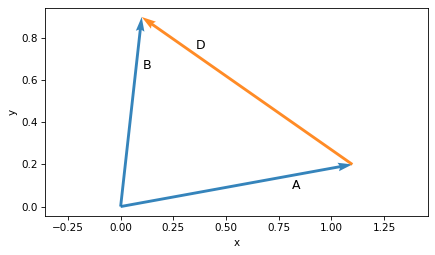

In [11]:
plot_vector(A, label='A', label_pos=2)
plot_vector(B, label='B', label_pos=2)
plot_vector(D, origin=A, label='D', label_pos=2, color='C1')
plt.axis('equal')
decorate(xlabel='x', ylabel='y')

These examples show three ways to represent a vector: a point in Cartesian coordinates, an arrow with its tail at the origin, or an arrow at any other location.
They also show the graphical representation of vector addition and subtraction.

Now we'll use these vector operations to work with GPS data.

## GPS Data

To prepare for this chapter, I went for a short run wearing a watch that tracked my location using the Global Positioning System (GPS).
I downloaded the results as a GPX file, which is a standard format for storing GPS tracks.

We'll use `load_gpx` to parse the file and extract the data.

In [12]:
import gpxpy

def load_gpx(filename):
    """Load a GPX file and return a DataFrame with lat, lon, elevation, and time."""
    with open(filename, "r") as f:
        gpx = gpxpy.parse(f)

    records = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                records.append({
                    "time": point.time,
                    "latitude": point.latitude,
                    "longitude": point.longitude,
                    "elevation": point.elevation,
                })

    return pd.DataFrame(records)

In [13]:
df_all = load_gpx("oval_run.gpx")
df_all.head()

,time,latitude,longitude,elevation
0,2025-11-16 16:08:09+00:00,42.2934,-71.2637,59.2000
1,2025-11-16 16:08:10+00:00,42.2935,-71.2637,59.2000
2,2025-11-16 16:08:11+00:00,42.2935,-71.2637,59.2000
3,2025-11-16 16:08:17+00:00,42.2936,-71.2637,59.3000
4,2025-11-16 16:08:18+00:00,42.2936,-71.2637,59.3000


The result is a Pandas `DataFrame` with one row for each measurement and columns for time, latitude and longitude in degrees, and elevation in meters above sea level. 

For this example, we'll select a segment of the run starting from the 34th measurement.

In [14]:
df = df_all.iloc[34:].reset_index(drop=True)

To visualize the data, we'll extract an array of latitude-longitude pairs.

In [15]:
cols = ['latitude', 'longitude']
latlon = df[cols].values

Then we can use the `trajectory` function to plot it as a set of points in the plane -- with `fliplr` to flip the latitude and longitude columns so they correspond to x-y coordinates.

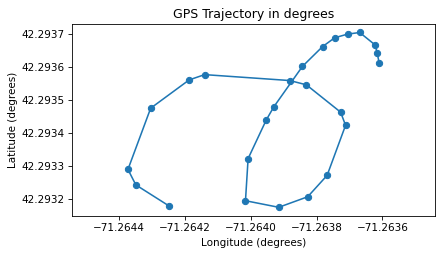

In [16]:
trajectory(np.fliplr(latlon), marker='o')

plt.axis("equal")
plt.gca().ticklabel_format(useOffset=False)

decorate(xlabel='Longitude (degrees)', ylabel='Latitude (degrees)', 
         title='GPS Trajectory in degrees')

If you are curious, you can probably figure out where I ran.

Working with latitude and longitude has some drawbacks: the units are in degrees rather than meters, and the relationship between these coordinates and actual distances depends on where you are on Earth.
But with a little geometry, we can convert latitude and longitude to distances in meters.

## Distances

To approximate the distance between two points on the surface of the earth, we'll convert each latitude-longitude pair to a 3D vector with its tail at the center of the earth, then compute the length of the vector difference between them.

As an example, let's extract the start and end points from the GPS trajectory.

In [17]:
start = latlon[0]
start

array([ 42.2936, -71.2636])

In [18]:
end = latlon[-1]
end

array([ 42.2932, -71.2642])

The key is to think of latitude and longitude as spherical coordinates, where longitude is the azimuth angle, measured in the plane of the equator from the reference point where longitude is 0, and latitude is the elevation angle, measured from the plane of the equator toward the poles.
The following figure shows how that works for the starting location.

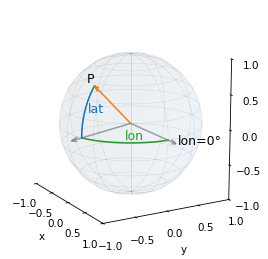

In [19]:
from utils import spherical_coords_diagram

spherical_coords_diagram(*start)

We can use `sph2cart()` to convert latitude and longitude to Cartesian coordinates -- we just have to convert from degrees to radians, and be careful about the order of the arguments.

In [20]:
from utils import sph2cart

def latlon_to_cartesian(latlon, radius=1.0):
    lat, lon = latlon.T
    result = sph2cart(np.deg2rad(lon), np.deg2rad(lat), radius)
    return result

Now we can convert our start and end points to vectors, using the average radius of the earth in meters.

In [21]:
r_earth = 6_371_000
start_vec = latlon_to_cartesian(start, r_earth)
start_vec

array([ 1513777.2923, -4462926.6972,  4287237.4095])

In [22]:
end_vec = latlon_to_cartesian(end, r_earth)
end_vec

array([ 1513738.0516, -4462974.3777,  4287201.6299])

Here's the difference between the vectors.

In [23]:
diff = end_vec - start_vec
diff

array([-39.2407, -47.6805, -35.7796])

The length of this difference vector is the distance between the points.

In [24]:
distance = norm(diff)
distance

71.3683

It's about 71 meters.

This calculation assumes that the earth is a sphere, so the radius is the same everywhere.
In fact, the earth is closer to an ellipsoid where the semi-axis from the center of the earth to the poles is about 6,357 km and the semi-axis from the center to the equator is about 6,378 km, a difference of about 0.3 percent.

This calculation also assumes that the distance between two points on the surface is a straight line, not an arc.
For small distances as in this example, the error due to this approximation is very small. 
To check, we can use the haversine formula, which computes the distance on an arc between two points.

In [25]:
from haversine import haversine, Unit

haversine_distance = haversine(start, end, unit=Unit.METERS)
haversine_distance

71.3684

The straight line approximation is off by only 0.0001%, which is negligible compared to the spherical approximation.

In [26]:
(distance - haversine_distance) / haversine_distance * 100

-0.0001

Let's encapsulate the straight-line approximation in a function.

In [27]:
def distance_between(start, end, r_earth=6_371_000):
    start_vec = latlon_to_cartesian(start, r_earth)
    end_vec = latlon_to_cartesian(end, r_earth)
    return norm(end_vec - start_vec)

Now we have everything we need to convert from latitude-longitude pairs to distances in meters.

## Converting Coordinates

To start, we'll compute the mean of the lat-lon pairs.

In [28]:
latlon_mean = latlon.mean(axis=0)
latlon_mean

array([ 42.2935, -71.2639])

Now we can compute the offset of each point from the center, multiplying by 1000 so the results are in millidegrees.

In [29]:
latlon_offset = (latlon - latlon_mean) * 1000
latlon_offset[:3]

array([[0.1458, 0.3005],
       [0.1758, 0.2945],
       [0.1998, 0.2885]])

To convert them to meters, we need to know how many meters correspond to one millidegree of latitude and longitude at our location.
We can use `distance_between` to compute this.

First, we'll create a vector that represents a location offset from `latlon_mean` by one millidegree in the direction of positive latitude, which is north.
Then we'll compute the distance between `latlon_mean` and this offset point.

In [30]:
north = [0.001, 0]
meters_north = distance_between(latlon_mean, latlon_mean+north)
meters_north

111.1949

Next we'll do the same thing with a point offset by one millidegree in the direction of positive longitude, which is east.

In [31]:
east = latlon_mean + [0, 0.001]
meters_east = distance_between(latlon_mean, east)
meters_east

82.2518

These distances tell us the number of meters per millidegree at this location.
We'll put these conversion factors in an array we'll use as a scaling vector.

In [32]:
scale = np.array([meters_north, meters_east])
scale

array([111.1949,  82.2518])

If we multiply the offsets in millidegrees by this scaling factor, the results are offsets in meters.

In [33]:
latlon_meters = latlon_offset * scale
latlon_meters[:3]

array([[16.2167, 24.715 ],
       [19.5525, 24.2215],
       [22.2212, 23.728 ]])

As the last step, we have to reverse the order of the columns -- because latitude corresponds to the `y` coordinate and longitude corresponds to the `x` coordinate.

In [34]:
positions = np.fliplr(latlon_meters)
positions[:3]

array([[24.715 , 16.2167],
       [24.2215, 19.5525],
       [23.728 , 22.2212]])

Let's plot the result as a trajectory.

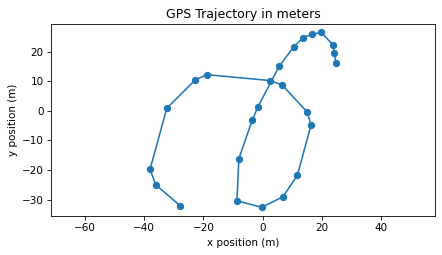

In [35]:
trajectory(positions, 'o-')
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)",
         title="GPS Trajectory in meters")

After all that, the trajectory in meters doesn't look very different from the trajectory in degrees of longitude and latitude.
But now that it is expressed in meters, we'll use it to compute velocity and acceleration.

## Position and Velocity

At this point we have a sequence of vectors that represent offsets from a central point.
So far we have visualized these vectors as points in space, but we can also visualize them as arrows with their tails at the origin, like this.

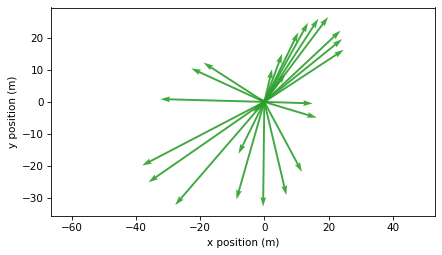

In [36]:
plot_vectors(positions, color="C2", width=0.005)
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

If we compute the difference between each successive pair of vectors, the result is a sequence of vectors that represent offsets between successive locations.
We'll use NumPy's `diff()` function -- with the keyword `axis=0`, it computes differences between rows.

In [37]:
displacements = np.diff(positions, axis=0)
displacements.shape

(24, 2)

The result has one row fewer than `positions`.
If we plot these differences with their tails at the corresponding locations, we can see that they connect the dots along the trajectory.

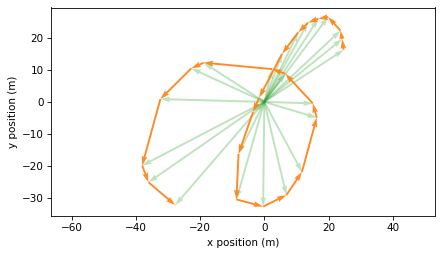

In [38]:
plot_vectors(positions, color="C2", width=0.005, alpha=0.3)
plot_vectors(displacements, positions[:-1], color="C1", width=0.005)
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

These differences represent offsets between successive measurements.
So we can estimate the total distance I ran by computing the lengths of these vectors and adding them up.

In [39]:
total_distance = norm(displacements, axis=1).sum()
total_distance

220.8934

To compute elapsed time, we'll convert the timestamps in `df["time"]` to seconds since the start.

In [40]:
start_time = df["time"].iloc[0]
ts = (df["time"] - start_time).dt.total_seconds().values
ts

array([ 0.,  1.,  2.,  4.,  5.,  6.,  7.,  9., 13., 14., 17., 21., 24.,
       26., 28., 32., 33., 36., 37., 42., 43., 46., 52., 53., 55.])

The elapsed time is the last element.

In [41]:
elapsed_time = ts[-1]
elapsed_time

55.0000

My average speed is total distance divided by elapsed time, which is about 4 meters per second.
For comparison, the world record time for 200 meters is 19.19 seconds (set by Usain Bolt in 2009), which is 10.4 meters per second.
In my defense, the route I ran has sharper turns than a standard track.

In [42]:
total_distance / elapsed_time

4.0162

In [43]:
200 / 19.19

10.4221

Now let's see how my velocity changed over time.

To convert displacements to velocities, we have to divide through by the time between measurements.
We can use `diff` to compute the time intervals.

In [44]:
dts = np.diff(ts)
dts

array([1., 1., 2., 1., 1., 1., 2., 4., 1., 3., 4., 3., 2., 2., 4., 1., 3.,
       1., 5., 1., 3., 6., 1., 2.])

The time between measurements is usually one second, but sometimes longer. 
We can compute velocity by dividing displacements by time differences.

In [45]:
velocities = displacements / dts[:, None]
velocities.shape

(24, 2)

The results are velocity vectors in meters per second.
The following figure shows these vectors with their tails at the corresponding positions.

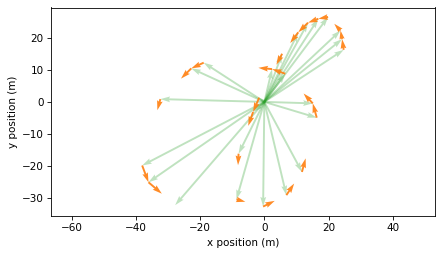

In [46]:
plot_vectors(positions, color="C2", width=0.005, alpha=0.3)
plot_vectors(velocities, positions[:-1], color="C1", width=0.005)
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

I think this is a good way to visualize position and velocity, but it is not technically correct because the position and velocity vectors are not in the same units.
As an alternative, we can plot the velocity vectors with their tails at the origin, like this:

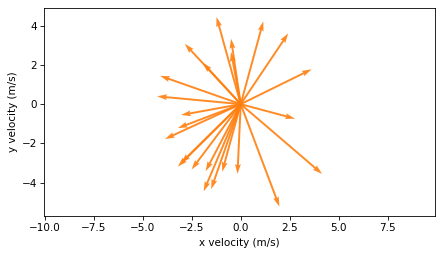

In [47]:
plot_vectors(velocities, color="C1", width=0.005)
plt.axis("equal")
decorate(xlabel="x velocity (m/s)", ylabel="y velocity (m/s)")

In this version, it is less clear what's happening physically, but this representation will be useful in the next section when we compute acceleration.

The magnitude of each velocity vector is the speed, which we can compute with `norm()`.

In [48]:
speeds = norm(velocities, axis=1)
speeds.shape

(24,)

Each velocity vector is computed from two consecutive positions, so the time we associate with it is the midpoint of the two measurement times.

In [49]:
ts_vel = (ts[:-1] + ts[1:]) / 2
ts_vel

array([ 0.5,  1.5,  3. ,  4.5,  5.5,  6.5,  8. , 11. , 13.5, 15.5, 19. ,
       22.5, 25. , 27. , 30. , 32.5, 34.5, 36.5, 39.5, 42.5, 44.5, 49. ,
       52.5, 54. ])

This figure shows speed over time.

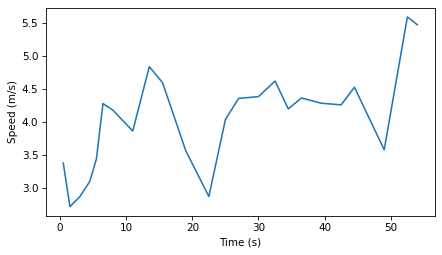

In [50]:
plt.plot(ts_vel, speeds)
decorate(xlabel="Time (s)", ylabel="Speed (m/s)")

The results are noisy because the measurements are noisy -- and taking the difference between successive measurements tends to amplify the noise.

## From Velocity to Acceleration

To get from position to velocity, we computed differences between successive positions, `displacements`, and divided by differences in measurement times, `dts`.

Now to get from velocity to acceleration, we'll compute differences between successive velocities and divide again by differences in times.

In [51]:
dvs = np.diff(velocities, axis=0)
dvs.shape

(23, 2)

Now we'll plot these changes in velocity with their tails at the corresponding velocity vectors.

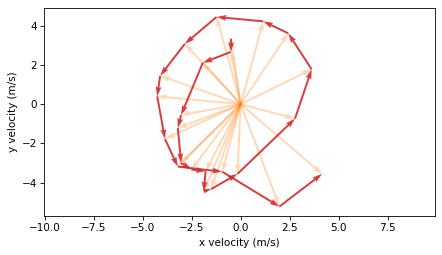

In [52]:
plot_vectors(velocities, color="C1", width=0.005, alpha=0.3)

plot_vectors(dvs, velocities[:-1], width=0.005, color="C3")
plt.axis("equal")
decorate(xlabel="x velocity (m/s)", ylabel="y velocity (m/s)")

To compute acceleration, we divide the velocity changes by the time intervals between velocity measurements.

In [53]:
dts_vel = np.diff(ts_vel)
accelerations = dvs / dts_vel[:, None]

To visualize the results, we'll plot each acceleration vector with its tail at the head of the corresponding velocity vector.

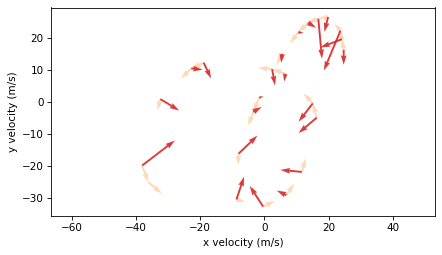

In [54]:
plot_vectors(velocities, positions[:-1], color="C1", width=0.005, alpha=0.3)

plot_vectors(accelerations, positions[:-2], scale=7, color="C3", width=0.005)
plt.axis("equal")
decorate(xlabel="x velocity (m/s)", ylabel="y velocity (m/s)")

Again, it's not completely correct to plot velocity and acceleration on the same axes, because they are not in the same units.
But this representation shows that acceleration vectors point toward the center of the curve, which is characteristic of **centripetal acceleration** -- the acceleration needed to make an object follow a curved path.

The magnitude of acceleration indicates how quickly velocity is changing.

In [55]:
magnitudes_acc = norm(accelerations, axis=1)
magnitudes_acc

array([0.6672, 1.0287, 1.927 , 0.6872, 1.7867, 0.4201, 0.2415, 0.4135,
       0.1998, 0.4436, 1.162 , 1.0639, 1.0941, 0.4713, 0.9583, 1.0604,
       1.0308, 0.3519, 0.7383, 0.7773, 0.5059, 0.9769, 1.8297])

Each acceleration vector corresponds to the midpoint of two velocity times.

In [56]:
ts_acc = (ts_vel[:-1] + ts_vel[1:]) / 2
ts_acc

array([ 1.  ,  2.25,  3.75,  5.  ,  6.  ,  7.25,  9.5 , 12.25, 14.5 ,
       17.25, 20.75, 23.75, 26.  , 28.5 , 31.25, 33.5 , 35.5 , 38.  ,
       41.  , 43.5 , 46.75, 50.75, 53.25])

Here's the magnitude of acceleration over time.

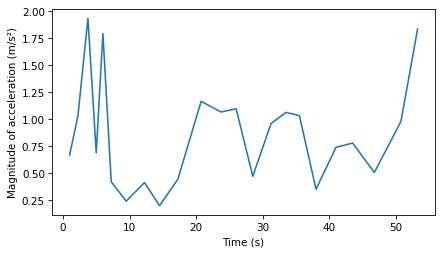

In [57]:
plt.plot(ts_acc, magnitudes_acc)
decorate(xlabel='Time (s)', ylabel='Magnitude of acceleration (m/s²)')

Again, the results are noisy -- in general, if the measurements are noisy, the velocities we compute are noisier, and the accelerations are even noisier.

## From Acceleration to Velocity

In the example so far, we started with position, used `diff()` to compute velocity, and used `diff()` again to compute acceleration.

Now suppose instead using a system like GPS to measure position, we use a device like an accelerometer to measure acceleration.
Most cell phones have an accelerometer that can be used to detect motion, orientation, and sudden changes in movement -- it is used for features like screen rotation, step counting, image stabilization, and crash detection.

In theory we can use a sequence of measurements from an accelerometer to estimate velocity, and use velocity to estimate position.
In this section we'll see how that works -- but we'll also see why it is not always a practical solution.

Suppose that when I was running, I recorded acceleration in the `x` and `y` directions.
To simulate the results of this hypothetical experiment, we'll use the acceleration vectors we just computed.

To get from acceleration to velocity, we have to start from a stand-still, or a known velocity.
For this example, we'll use the velocity we computed as a known initial value.

In [58]:
v0 = velocities[0]

We'll multiply by `dts_vel` to get the changes in velocity, then use `cumsum` to compute the cumulative sum of the changes.

In [59]:
dvs_from_acc = accelerations * dts_vel[:, None]
velocities_from_acc = np.vstack([[v0], v0 + np.cumsum(dvs_from_acc, axis=0)])

Here we're using `vstack` to add the initial velocity as the first row of the array.

The velocities we get from the cumulative sum of acceleration are the same as the ones we get from differences in position, except for floating-point errors.

In [60]:
np.allclose(velocities, velocities_from_acc)

True

In [61]:
speeds_from_acc = norm(velocities_from_acc, axis=1)
speeds_from_acc

array([3.3722, 2.7139, 2.8635, 3.0937, 3.4331, 4.275 , 4.1739, 3.859 ,
       4.8334, 4.5913, 3.562 , 2.8666, 4.0327, 4.3529, 4.3795, 4.6157,
       4.1946, 4.3592, 4.2794, 4.2556, 4.5223, 3.5745, 5.5866, 5.4694])

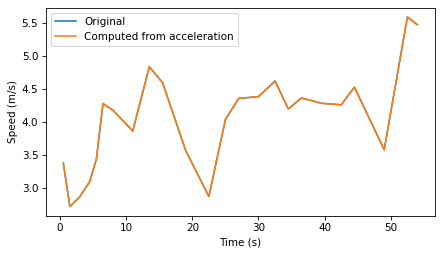

In [62]:
plt.plot(ts_vel, speeds, label='Original')
plt.plot(ts_vel, speeds_from_acc, label='Computed from acceleration')
decorate(xlabel="Time (s)", ylabel="Speed (m/s)")

Compare the reconstructed velocity to the measured one.
They should be close, but not identical because of noise and numerical error.

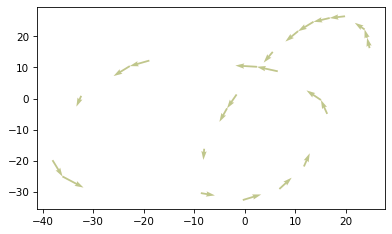

In [63]:
plot_vectors(velocities, positions[:-1], color="C1", width=0.005, alpha=0.3)
plot_vectors(velocities_from_acc, positions[:-1], color="C2", width=0.005, alpha=0.3)

To get from velocity to position, the process is almost the same.
We multiply velocities by time differences to get displacements.

In [64]:
displacements_from_acc = velocities_from_acc * dts[:, None]

Then, starting from a known position, we add in the cumulative sum of the displacements.

In [65]:
x0 = positions[0]
positions_from_acc = np.vstack([[x0], x0 + np.cumsum(displacements_from_acc, axis=0)])

The results are the same as the positions we started with, except for floating-point errors.

In [66]:
np.allclose(positions, positions_from_acc)

True

## An Imperfect World

In the previous example, we were able to get from acceleration to position with near-perfect precision.
But in the real world, measurements are not perfect.
To simulate measurement error, we'll generate a random noise factor and multiply by the accelerations we computed.

In [67]:
np.random.seed(1)

In [68]:
noise_factor = np.random.normal(1, 0.02, size=accelerations.shape)
accelerations_noisy = accelerations * noise_factor

In [69]:
mean_magnitude = norm(accelerations, axis=1).mean()
mean_error = np.abs(accelerations_noisy - accelerations).mean()
relative_error = mean_error / mean_magnitude * 100
relative_error  # should be ~1%

0.9725

The simulated measurements are off by about 1% on average.
Now we'll use the noisy accelerations to estimate velocity.

In [70]:
dvs_noisy = accelerations_noisy * dts_vel[:, None]
velocities_noisy = np.vstack([[v0], v0 + np.cumsum(dvs_noisy, axis=0)])

And we'll use the estimated velocities to estimate the trajectory.

In [71]:
displacements_noisy = velocities_noisy * dts[:, None]
positions_noisy = np.vstack([[x0], x0 + np.cumsum(displacements_noisy, axis=0)])

Here's the trajectory we constructed from noisy measurements compared to the original GPS track.

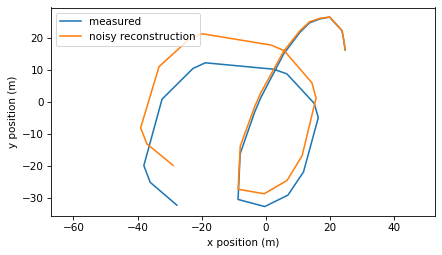

In [72]:
trajectory(positions, label="measured")
trajectory(positions_noisy, label="noisy reconstruction")
plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)")

We can see that the two trajectories diverge. At the end, they differ by about 12 meters.

In [73]:
error = positions_noisy[-1] - positions[-1] 
norm(error)

12.4361

So this way of estimating position from acceleration is not accurate.
And what we simulated is nearly the best case scenario, where the initial position and velocity are known exactly, and the measured accelerations are only off by 1%.

In a real scenario, we don't know the initial conditions precisely, and real measurements of acceleration are probably not that accurate, especially taken from a phone carried by a running person.

Using an accelerometer to estimate small displacements over a short period of time might be possible in some conditions, but it is not generally practical.

## Discussion

This chapter introduces addition and subtraction of vectors, and several ways to represent vectors graphically: as points in a Cartesian plane (or 3D space), as arrows with their tails at the origin, or as arrows with their tails at other locations.

The vectors in this chapter were considered **free vectors**, which means that they represent a direction and magnitude, but they don't have a particular position in space.
In Chapter xxx, we will work with **bound vectors**, which have direction, magnitude, and position.

As applications of addition and subtraction, we computed the distance between two points on the surface of a sphere, which we used to convert measurements of latitude and longitude to Cartesian coordinates.

Then we used `diff()` to subtract successive positions to get velocity, and subtract successive velocities to get acceleration.
If you are familiar with calculus, you might recognize these steps as a numerical form of differentiation.
A challenge of numerical differentiation is that it amplifies measurement noise, so velocity is noisier than position and acceleration is noisier than velocity.

Finally, we used `cumsum()` to add up accelerations to estimate velocity, and add up velocities to estimate positions.
You might recognize these steps as a form of integration.
A challenge of numerical integration is that errors accumulate, so the results are less accurate for longer trajectories.

## Exercises

## Exercise

In this chapter, we approximated the distance between nearby GPS points by converting latitude and longitude to 3D Cartesian vectors and computing the length of the difference between vectors. This works well for short distances, but for points that are far apart on the surface of the Earth, it is less accurate.

In this exercise, we'll compare the straight-line approximation to the great-circle distance between two cities.

Use the following latitude and longitude coordinates (in degrees):

- Boston, MA: latitude 42.3601°, longitude −71.0589°
- London, UK: latitude 51.5074°, longitude −0.1278°

1. Use the `distance_between` function from this chapter to compute the straight-line distance between Boston and London, which would burrow through the Earth.

2. Use the `haversine` function to compute the great-circle distance between the same two points. This distance corresponds to the shortest path along the surface of the Earth.

3. Compute the absolute difference between the two distances, in meters.

4. Compute the relative difference between the two distances, as a percentage of the great-circle distance.

In [74]:
# Solution

# Boston and London (lat, lon) in degrees
boston = np.array([42.3601, -71.0589])
london = np.array([51.5074,  -0.1278])

# 1) Straight-line (chord) distance using our function
d_straight = distance_between(boston, london)
d_straight

5115693.1301

In [75]:
# Solution

# 2) Great-circle distance using haversine
from haversine import haversine, Unit
d_gc = haversine(boston, london, unit=Unit.METERS)
d_gc

5264176.3104

In [76]:
# Solution

# 3) Absolute difference in meters
abs_diff = d_gc - d_straight
abs_diff

148483.1803

In [77]:
# Solution

# 4) Relative difference as a percentage
rel_diff = abs_diff / d_gc * 100
rel_diff

2.8206

## Exercise: Flying from Boston to London with a Jet Stream

An airplane flying from Boston to London has a measured airspeed -- that is, speed relative to the surrounding air -- and a measured heading.
The plan is flying in the jet stream, a river of air that flows from west to east across the Atlantic Ocean.

In this exercise, you will add the velocity of the plane, relative to the air, and the velocity of the jet stream, relative to the ground, to get the velocity of the plane relative to the ground.

Assume the plane's airspeed is 250 m/s and it's heading is 60°, measured clockwise from north, as on a magnetic compass.
Assume that the speed of the jet stream is 50 m/s, blowing toward 90° (due east).

1. Convert the speed and heading of the plane to a 2D Cartesian velocity vector.
2. Convert the speed and heading of the jet stream to a 2D Cartesian velocity vector.
3. Compute the sum of these velocity vectors.
4. Use `plot_vector` to plot the two velocity vectors and their sum.
5. Convert the total velocity back to a ground speed and ground heading.

Supposing that the plane intended to fly at a heading of 60°, how much is its effective heading off by?

You can use `pol2cart` and `cart2pol`, which convert between polar coordinates (speed and heading) and Cartesian coordinates (x and y components) -- but note that these function expect and return headings in radians counterclockwise from the `x` axis.

In [78]:
# Airspeed and heading (approximate Boston → London heading)
airspeed = 250.0          # m/s
heading_air_deg = 60.0    # degrees (measured clockwise from north)

# Jet stream: speed and heading (direction the wind is blowing toward)
wind_speed = 50.0         # m/s
heading_wind_deg = 90.0   # degrees (east)

In [79]:
# Solution

# Convert headings to radians, measured from +x (east), counterclockwise
# Our convention:
#   0° = east, 90° = north
phi_air = np.deg2rad(90 - heading_air_deg)
phi_wind = np.deg2rad(90 - heading_wind_deg)

In [80]:
# Solution

# Convert to Cartesian vectors

from utils import pol2cart 

v_air = pol2cart(airspeed, phi_air)
v_wind = pol2cart(wind_speed, phi_wind)

In [81]:
# Solution

# Ground velocity is the vector sum
v_ground = v_air + v_wind

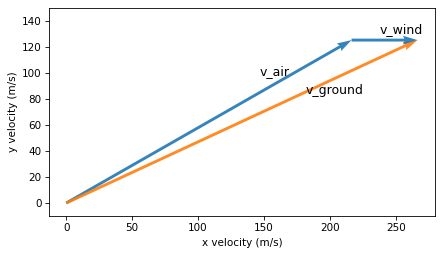

In [82]:
# Solution

plot_vector(v_air, label='v_air', label_pos=10)
plot_vector(v_ground, label='v_ground', label_pos=2, color='C1')
plot_vector(v_wind, v_air, label='v_wind', label_pos=10)
decorate(xlabel='x velocity (m/s)', ylabel='y velocity (m/s)', ylim=[-10, 150])

In [83]:
# Solution

# Convert back to speed and heading
from utils import cart2pol

ground_speed, phi_ground = cart2pol(v_ground)
ground_speed

294.3648

In [84]:
# Solution

# Convert heading back to compass convention (degrees from north)
ground_heading_deg = (90 - np.rad2deg(phi_ground)) % 360
ground_heading_deg

64.8719

### Exercise

In this chapter, we estimated velocity by taking differences between successive position measurements. Because GPS measurements are noisy, the estimated velocities that are even noisier.

In this exercise, we'll smooth the GPS track before computing velocity, and compare the results to the unsmoothed estimates.

SciPy provides a function that fits a smooth 2D parametric spline to the GPS positions and measurement times.
The `s` parameter controls the smoothness of the fitted path.

In [85]:
from scipy.interpolate import splprep, splev

tck, _ = splprep(positions.T, u=ts, s=10)

Now we can use `splev()` to evaluate the spline at equally-spaced points in time, and I'll put the results in an array with the same shape as position.

In [86]:
ts_equal = np.linspace(ts[0], ts[-1], 50)
xy = splev(ts_equal, tck)

positions_smooth = np.transpose(xy)
positions_smooth.shape

(50, 2)

1. Use `trajectory()` to plot the original and smoothed trajectories and see how they compare.

2. Use the smoothed positions to compute displacement and total distance traveled. How does the length of the smoothed trajectory compare to the original.

3. Use the smoothed positions and `ts_equal` to estimate smoothed velocities.

4. Compute the speed from the velocity vectors and plot speed versus time.

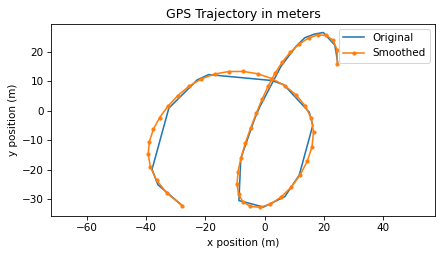

In [87]:
# Solution

trajectory(positions, label='Original')
trajectory(positions_smooth, '.-', label='Smoothed')

plt.axis("equal")
decorate(xlabel="x position (m)", ylabel="y position (m)",
         title="GPS Trajectory in meters")

In [88]:
# Solution

displacements_smooth = np.diff(positions_smooth, axis=0)
total_distance_smooth = norm(displacements_smooth, axis=1).sum()
total_distance_smooth, total_distance

(222.8621, 220.8934)

In [89]:
# Solution

dts_equal = np.diff(ts_equal)
velocities_smooth = displacements_smooth / dts_equal[:, None]
speeds_smooth = norm(velocities_smooth, axis=1)

In [90]:
# Solution

ts_vel_equal = (ts_equal[:-1] + ts_equal[1:]) / 2

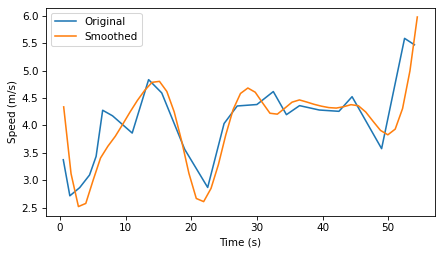

In [91]:
# Solution

plt.plot(ts_vel, speeds, label="Original")
plt.plot(ts_vel_equal, speeds_smooth, label="Smoothed")
decorate(xlabel="Time (s)", ylabel="Speed (m/s)")

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)